### <b>Load Required Libraries</b>

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import math
import os
import random

from types import SimpleNamespace
from scipy.fftpack import dct, idct

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80
plt.rcParams.update({'font.size': 12})

### <b>Dataset Download</b>

* CelebA Validation Dataset

In [3]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZ_J1R-C2pZNk9IR4esbay0BBT1HfPximGEEDT8cpbtnCA?download=1 -O celeba_hq_validation_100.zip
!unzip celeba_hq_validation_100.zip -d ./celeba_hq_validation_100

In [4]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_dir = './celeba_hq_validation_100'
val_datasets = datasets.ImageFolder(data_dir, transforms_val)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=128, shuffle=True, num_workers=4)
print('Validation dataset size:', len(val_datasets))

class_names = val_datasets.classes
print('Class names:', class_names)

Validation dataset size: 200
Class names: ['female', 'male']


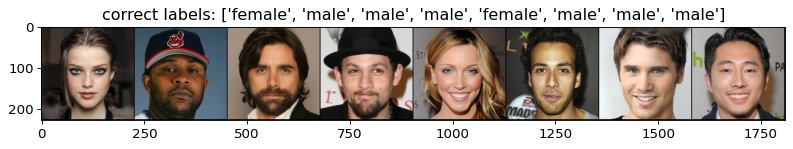

In [5]:
# display a torch image
def imshow(inputs, classes, message):
    inputs_data = inputs
    classes_data = classes
    if inputs.shape[0] > 8: # display maximum 4 images
        inputs_data = inputs[:8]
        classes_data = classes[:8]
    inputs_data = torchvision.utils.make_grid(inputs_data)
    # torch.Tensor => numpy
    inputs_data = inputs_data.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(inputs_data)
    plt.title(message + ': ' + str([class_names[x] for x in classes_data]))
    plt.show()


# visualize a batch of validation image
iterator = iter(val_dataloader)
inputs, classes = next(iterator)
imshow(inputs, classes, 'correct labels')

### <b>Load Pre-trained Classification Model</b>

* Set the model to the evaluation mode.

In [6]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1 -O classification_model.pth

--2021-03-03 23:54:41--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/face_gender_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVmQ5YkZXenF6dE1yWFJEZE5uQ0hRa0JzSGFNNG41XzFxMWZ1ZTc3dnRRVnR3P3J0aW1lPXozcU90cF9lMkVn [following]
--2021-03-03 23:54:41--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/face_gender_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvb

In [15]:
save_path = 'classification_model.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model = model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### <b>Load Pre-trained Feature Extractor</b>

In [28]:
# VGG feature extractor
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406], device="cuda").view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225], device="cuda").view(-1, 1, 1)

        extractor = models.vgg16(pretrained=True).features

        index = 0
        self.layers = nn.ModuleList([])
        for i in range(len(n_layers)):
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = (x - self.mean) / self.std

        result = []
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result


def extract_feature(image, feature_extractor, size):
    features = feature_extractor(F.interpolate(image, size=size))

    return features

In [29]:
feature_extractor = FeatureExtractor(n_layers=[4, 7, 14]).cuda()

### <b>Define Utilities</b>

In [44]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# applies the normalization transformations
def apply_normalization(imgs):
    imgs_tensor = imgs.clone()
    if imgs.dim() == 3: # color image
        for i in range(imgs_tensor.size(0)):
            imgs_tensor[i, :, :] = (imgs_tensor[i, :, :] - MEAN[i]) / STD[i]
    else: # grayscale image
        for i in range(imgs_tensor.size(1)):
            imgs_tensor[:, i, :, :] = (imgs_tensor[:, i, :, :] - MEAN[i]) / STD[i]
    return imgs_tensor


# get prediction outputs
def get_preds(model, inputs, batch_size, return_cpu=True):
    num_batches = int(math.ceil(inputs.size(0) / float(batch_size)))
    all_preds, all_probs = None, None
    for i, input in enumerate(inputs): # save images
        save_image(input, f'input{i}.png')
    for i in range(num_batches):
        upper = min((i + 1) * batch_size, inputs.size(0))
        temp_inputs = inputs[(i * batch_size):upper].clone()
        cnt = 0
        for j in range(i * batch_size, upper):
            temp_inputs[cnt] = transforms_val(Image.open(f'input{j}.png'))
            cnt += 1
        input = apply_normalization(temp_inputs)
        with torch.no_grad():
            output = torch.nn.Softmax(dim=1)(model.forward(input.cuda()))
        prob, pred = output.max(1)
        if return_cpu:
            prob = prob.data.cpu()
            pred = pred.data.cpu()
        else:
            prob = prob.data
            pred = pred.data
        if i == 0:
            all_probs = prob
            all_preds = pred
        else:
            all_probs = torch.cat((all_probs, prob), 0)
            all_preds = torch.cat((all_preds, pred), 0)
    return all_preds, all_probs


# get low frequency noises
def sample_gaussian_torch(image_size, dct_ratio=1.0):
    x = torch.zeros(image_size)
    fill_size = int(image_size[-1] * dct_ratio)
    x[:, :, :fill_size, :fill_size] = torch.randn(x.size(0), x.size(1), fill_size, fill_size)
    if dct_ratio < 1.0:
        x = torch.from_numpy(idct(idct(x.numpy(), axis=3, norm='ortho'), axis=2, norm='ortho'))
    return x

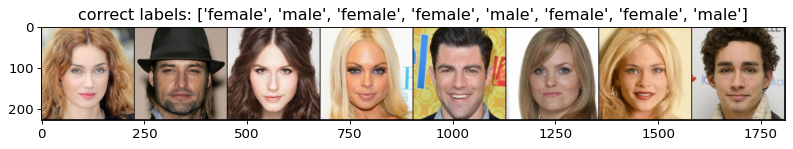

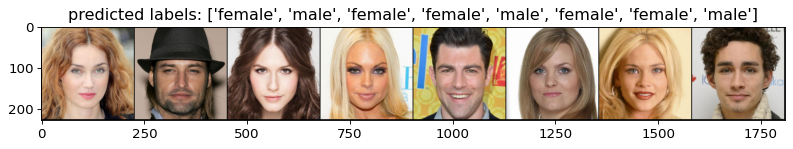

In [45]:
# visualize a batch of validation image
iterator = iter(val_dataloader)
inputs, classes = next(iterator)
imshow(inputs, classes, 'correct labels')

# visualize a prediction result
preds, _ = get_preds(model, inputs.cuda(), batch_size=8, return_cpu=False)
imshow(inputs, preds, 'predicted labels')

### <b>Boundary Attack Functions</b>

In [46]:
def boundary_attack(
    model, images, labels, init=None, max_iters=1000,
    spherical_step=0.01, source_step=0.01, step_adaptation=1.5, reset_step_every=50,
    dct_mode=True, dct_ratio=1.0):


    images = images.cuda()
    labels = labels.cuda()
    batch_size = images.size(0)
    base_preds, _ = get_preds(model, images.cuda(), batch_size=batch_size, return_cpu=False)
    images_vec = images.view(batch_size, -1)
    images_features = extract_feature(images, feature_extractor, 256)
    imshow(images.cpu(), labels, 'original labels')


    """ Prepare initial images """
    init = torch.zeros(images.size()).cuda()
    preds = labels.clone()
    while preds.eq(labels).sum() > 0:
        print("Sampling initial images")
        idx = torch.arange(0, batch_size).long().cuda()[preds.eq(labels)]
        iterator = iter(val_dataloader)
        rand_image, _ = next(iterator)
        init[idx] = rand_image[idx].cuda()
        preds, _ = get_preds(model, init, batch_size=batch_size, return_cpu=False)
    preds, _ = get_preds(model, init, batch_size=batch_size, return_cpu=False)
    perturbed = init.clone()
    print('[Initial adversairal examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')


    """ Prepare Start Points """
    min_alpha = torch.zeros(batch_size).cuda()
    max_alpha = torch.ones(batch_size).cuda()
    for _ in range(10): # binary search
        alpha = (min_alpha + max_alpha) / 2
        alpha_expanded = alpha.view(batch_size, 1, 1, 1).expand_as(init)
        interp = alpha_expanded * init + (1 - alpha_expanded) * images
        preds, _ = get_preds(model, interp, batch_size=batch_size, return_cpu=False)
        min_alpha[preds.eq(labels)] = alpha[preds.eq(labels)]
        max_alpha[preds.ne(labels)] = alpha[preds.ne(labels)]
        perturbed[preds.ne(labels)] = interp[preds.ne(labels)] # untargeted attack (label should be not equal)
    print('[Start points]')
    preds, _ = get_preds(model, perturbed, batch_size=batch_size, return_cpu=False)
    imshow(perturbed.cpu(), preds, 'predicted labels')


    """ Attack Start """
    # recording success rate of previous moves for adjusting step size
    spherical_succ = torch.zeros(batch_size, reset_step_every).cuda()
    source_succ = torch.zeros(batch_size, reset_step_every).cuda()
    spherical_steps = (torch.ones(batch_size) * spherical_step).cuda()
    source_steps = (torch.ones(batch_size) * source_step).cuda()
    
    for i in range(max_iters):
        candidates, spherical_candidates = generate_candidate(
            images, perturbed, spherical_steps, source_steps, dct_mode=dct_mode, dct_ratio=dct_ratio)
        # additional query on spherical candidate for RGB-BA
        if not dct_mode: 
            spherical_preds, _ = get_preds(model, spherical_candidates, batch_size=batch_size, return_cpu=False)
        else:
            spherical_preds = labels + 1 # Make the spherical success rate = 100%
        source_preds, _ = get_preds(model, candidates, batch_size=batch_size, return_cpu=False)
        spherical_succ[:, i % reset_step_every][spherical_preds.ne(labels)] = 1
        source_succ[:, i % reset_step_every][source_preds.ne(labels)] = 1

        # reject moves if they result incorrectly classified images
        idx = torch.arange(0, batch_size).long().cuda()[source_preds.eq(labels)] # attack fail indexes
        candidates[idx] = perturbed[idx] # then, reject
        # reject moves if MSE is already low enough
        if i > 0:
            candidates[mse_prev.lt(1e-6)] = perturbed[mse_prev.lt(1e-6)]
  
        # record current stats
        perturbed_features = extract_feature(perturbed, feature_extractor, 256)
        candidates_features = extract_feature(candidates, feature_extractor, 256)
        feature_distance_prev = 0
        feature_distance = 0
        for j in range(len(images_features)):
            feature_distance_prev += nn.MSELoss(reduction='mean')(images_features[j], perturbed_features[j])
            feature_distance += nn.MSELoss(reduction='mean')(images_features[j], candidates_features[j])
        perturbed_vec = perturbed.view(batch_size, -1)
        candidates_vec = candidates.view(batch_size, -1)
        mse_prev = (images_vec - perturbed_vec).pow(2).mean(1)
        mse = (images_vec - candidates_vec).pow(2).mean(1)
        mse_reduction = 100 * (mse_prev.mean() - mse.mean()) / mse_prev.mean()
        feature_reduction = 100 * (feature_distance_prev - feature_distance) / feature_distance_prev
        norms = (images_vec - candidates_vec).norm(2, 1)
        print('Iteration %d:  MSE = %.6f (reduced by %.4f%%), L2 norm = %.4f Feature distance = %.4f (reduced by %.4f%%)' % (i + 1, mse.mean(), mse_reduction, norms.mean(), feature_distance, feature_reduction))
        
        # adjust step size
        if (i + 1) % reset_step_every == 0:
            spherical_steps, source_steps, p_spherical, p_source = adjust_step(spherical_succ, source_succ, spherical_steps, source_steps, step_adaptation, dct_mode=dct_mode)
            spherical_succ.fill_(0)
            source_succ.fill_(0)
            print('Spherical success rate = %.4f, new spherical step = %.4f' % (p_spherical.mean(), spherical_steps.mean()))
            print('Source success rate = %.4f, new source step = %.4f' % (p_source.mean(), source_steps.mean()))

        perturbed = candidates

        if (i + 1) % 200 == 0:
            imshow(perturbed.cpu(), labels_batch, 'original labels')
            
    return perturbed.cpu()
        
    
def generate_candidate(images, perturbed, spherical_steps, source_steps, dct_mode='none', dct_ratio=1.0):
    batch_size = images.size(0)
    unnormalized_source_direction = images - perturbed
    source_norm = unnormalized_source_direction.view(batch_size, -1).norm(2, 1)
    source_direction = unnormalized_source_direction.div(source_norm.view(batch_size, 1, 1, 1).expand_as(unnormalized_source_direction))
    
    perturbation = sample_gaussian_torch(images.size(), dct_ratio=dct_ratio)
    perturbation = perturbation.cuda()
    
    if not dct_mode:
        dot = (images * perturbation).view(batch_size, -1).sum(1)
        perturbation -= source_direction.mul(dot.view(batch_size, 1, 1, 1).expand_as(source_direction))
    alpha = spherical_steps * source_norm / perturbation.view(batch_size, -1).norm(2, 1)
    perturbation = perturbation.mul(alpha.view(batch_size, 1, 1, 1).expand_as(perturbation))
    if not dct_mode:
        D = spherical_steps.pow(2).add(1).pow(-0.5)
        direction = perturbation - unnormalized_source_direction
        spherical_candidates = (images + direction.mul(D.view(batch_size, 1, 1, 1).expand_as(direction)))
    else:
        spherical_candidates = perturbed + perturbation
    spherical_candidates = spherical_candidates.clamp(0, 1)
    
    new_source_direction = images - spherical_candidates
    new_source_direction_norm = new_source_direction.view(batch_size, -1).norm(2, 1)
    length = source_steps * source_norm
    deviation = new_source_direction_norm - source_norm
    length += deviation
    length[length.le(0)] = 0
    length = length / new_source_direction_norm
    candidates = (spherical_candidates + new_source_direction.mul(length.view(batch_size, 1, 1, 1).expand_as(new_source_direction)))
    candidates = candidates.clamp(0, 1)
    
    return (candidates, spherical_candidates)


def adjust_step(spherical_succ, source_succ, spherical_steps, source_steps, step_adaptation, dct_mode='none'):
    p_spherical = spherical_succ.mean(1)
    num_spherical = spherical_succ.sum(1)
    p_source = torch.zeros(source_succ.size(0)).cuda()
    for i in range(source_succ.size(0)):
        if num_spherical[i] == 0:
            p_source[i] = 0
        else:
            p_source[i] = source_succ[i, :][spherical_succ[i].eq(1)].mean()
    if not dct_mode:
        # adjust spherical steps when using RGB-BA
        spherical_steps[p_spherical.lt(0.2)] = spherical_steps[p_spherical.lt(0.2)] / step_adaptation
        spherical_steps[p_spherical.gt(0.6)] = spherical_steps[p_spherical.gt(0.6)] * step_adaptation
    source_steps[num_spherical.ge(10) * p_source.lt(0.2)] = source_steps[num_spherical.ge(10) * p_source.lt(0.2)] / step_adaptation
    source_steps[num_spherical.ge(10) * p_source.gt(0.6)] = source_steps[num_spherical.ge(10) * p_source.gt(0.6)] * step_adaptation
    return (spherical_steps, source_steps, p_spherical, p_source)

### <b>Run Attack</b>

[Attack start]


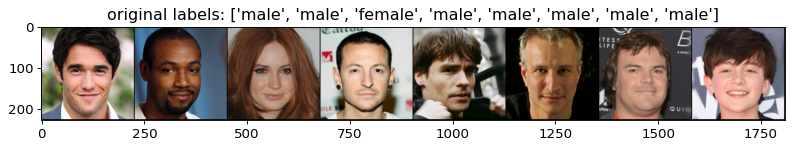

Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
[Initial adversairal examples]


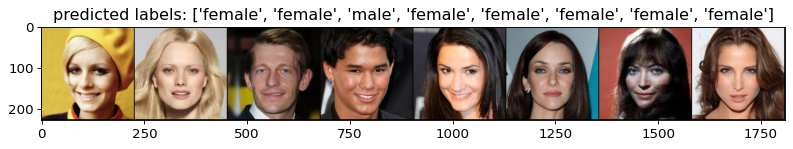

[Start points]


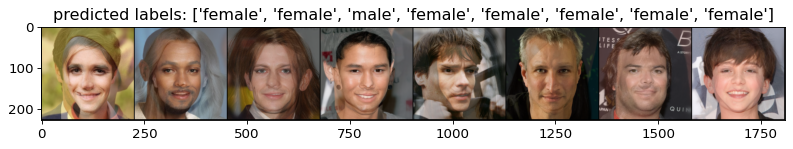

Iteration 1:  MSE = 0.037312 (reduced by 0.1361%), L2 norm = 68.2302 Feature distance = 42.0004 (reduced by 0.0592%)
Iteration 2:  MSE = 0.037262 (reduced by 0.1342%), L2 norm = 68.1789 Feature distance = 41.9619 (reduced by 0.0917%)
Iteration 3:  MSE = 0.037254 (reduced by 0.0213%), L2 norm = 68.1620 Feature distance = 41.9487 (reduced by 0.0314%)
Iteration 4:  MSE = 0.037240 (reduced by 0.0379%), L2 norm = 68.1402 Feature distance = 41.9352 (reduced by 0.0321%)
Iteration 5:  MSE = 0.037212 (reduced by 0.0753%), L2 norm = 68.1016 Feature distance = 41.9101 (reduced by 0.0598%)
Iteration 6:  MSE = 0.037208 (reduced by 0.0114%), L2 norm = 68.0945 Feature distance = 41.9056 (reduced by 0.0108%)
Iteration 7:  MSE = 0.037191 (reduced by 0.0446%), L2 norm = 68.0752 Feature distance = 41.8988 (reduced by 0.0162%)
Iteration 8:  MSE = 0.037138 (reduced by 0.1435%), L2 norm = 68.0341 Feature distance = 41.8668 (reduced by 0.0764%)
Iteration 9:  MSE = 0.037118 (reduced by 0.0526%), L2 norm = 68.

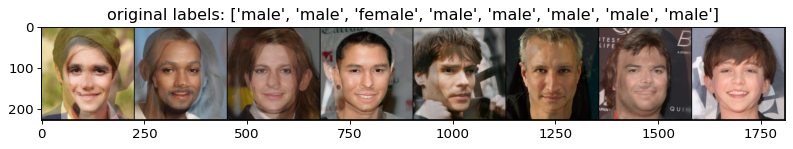

Iteration 201:  MSE = 0.032862 (reduced by 0.0198%), L2 norm = 64.1580 Feature distance = 40.0311 (reduced by 0.0159%)
Iteration 202:  MSE = 0.032857 (reduced by 0.0146%), L2 norm = 64.1534 Feature distance = 40.0293 (reduced by 0.0044%)
Iteration 203:  MSE = 0.032844 (reduced by 0.0410%), L2 norm = 64.1400 Feature distance = 40.0188 (reduced by 0.0262%)
Iteration 204:  MSE = 0.032796 (reduced by 0.1461%), L2 norm = 64.1045 Feature distance = 40.0059 (reduced by 0.0323%)
Iteration 205:  MSE = 0.032783 (reduced by 0.0403%), L2 norm = 64.0949 Feature distance = 40.0069 (reduced by -0.0025%)
Iteration 206:  MSE = 0.032759 (reduced by 0.0726%), L2 norm = 64.0785 Feature distance = 39.9986 (reduced by 0.0206%)
Iteration 207:  MSE = 0.032747 (reduced by 0.0354%), L2 norm = 64.0721 Feature distance = 39.9943 (reduced by 0.0108%)
Iteration 208:  MSE = 0.032707 (reduced by 0.1222%), L2 norm = 64.0444 Feature distance = 39.9731 (reduced by 0.0529%)
Iteration 209:  MSE = 0.032704 (reduced by 0.01

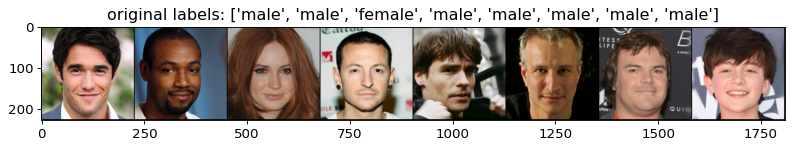

[Attack result examples]


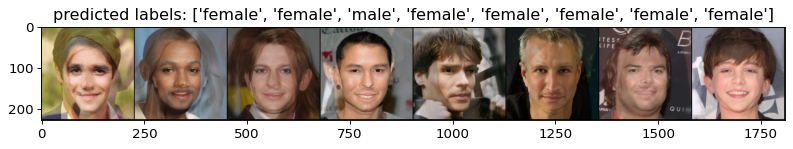

In [51]:
args = SimpleNamespace()
args.data_root = './celeba_hq_validation_100' # the root directory of a dataset
args.num_runs = 64 # number of repeated runs (number of images)
args.batch_size = 64 # batch size for parallel runs
args.num_steps = 300 # maximum number of iterations (number of queries)
args.perturb_mode = 'gaussian' # type of spherical perturbation sample (gaussian / dct)
args.spherical_step = 0.01 # spherical step size
args.source_step = 0.01 # source step size
args.dct_ratio = 1.0 # ratio of nonzero frequencies for dct

dct_mode = (args.perturb_mode == 'dct')

# load previously sampled set of images
testset = datasets.ImageFolder(args.data_root, transforms_val)
images = torch.zeros(args.num_runs, 3, 224, 224)
labels = torch.zeros(args.num_runs).long()
preds = labels + 1

# sample a new set of images that are correctly classified
while preds.ne(labels).sum() > 0:
    idx = torch.arange(0, images.size(0)).long()[preds.ne(labels)]
    for i in list(idx):
        images[i], labels[i] = testset[random.randint(0, len(testset) - 1)] # you can apply fixed seed
    preds[idx], _ = get_preds(model, images[idx], batch_size=args.batch_size)

# start attack
N = int(math.floor(float(args.num_runs) / float(args.batch_size)))
for i in range(N):
    print("==============================================================")
    print('[Attack start]')
    upper = min((i + 1) * args.batch_size, args.num_runs)
    images_batch = images[(i * args.batch_size):upper]
    labels_batch = labels[(i * args.batch_size):upper]
    perturbed = boundary_attack(
        model, images_batch, labels_batch, max_iters=args.num_steps,
        spherical_step=args.spherical_step, source_step=args.source_step,
        dct_mode=dct_mode, dct_ratio=args.dct_ratio)

    print('[Original examples]')
    imshow(images_batch.cpu(), labels_batch, 'original labels')

    preds, _ = get_preds(model, perturbed, batch_size=args.batch_size, return_cpu=False)
    print('[Attack result examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')

[Attack start]


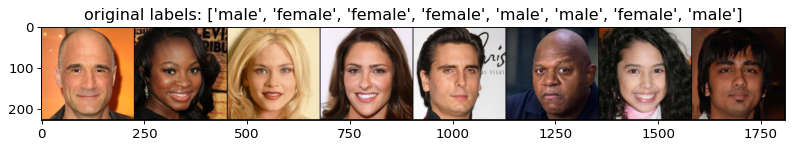

Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
[Initial adversairal examples]


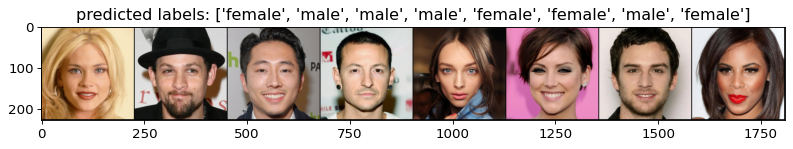

[Start points]


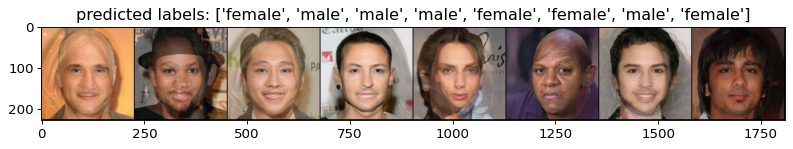

Iteration 1:  MSE = 0.040880 (reduced by 0.5482%), L2 norm = 72.5269 Feature distance = 44.7688 (reduced by 0.1478%)
Iteration 2:  MSE = 0.040547 (reduced by 0.8130%), L2 norm = 72.2529 Feature distance = 44.6527 (reduced by 0.2594%)
Iteration 3:  MSE = 0.040186 (reduced by 0.8903%), L2 norm = 71.9571 Feature distance = 44.5376 (reduced by 0.2579%)
Iteration 4:  MSE = 0.039846 (reduced by 0.8472%), L2 norm = 71.6599 Feature distance = 44.4051 (reduced by 0.2975%)
Iteration 5:  MSE = 0.039402 (reduced by 1.1141%), L2 norm = 71.2911 Feature distance = 44.2599 (reduced by 0.3269%)
Iteration 6:  MSE = 0.039037 (reduced by 0.9257%), L2 norm = 70.9901 Feature distance = 44.1313 (reduced by 0.2907%)
Iteration 7:  MSE = 0.038651 (reduced by 0.9901%), L2 norm = 70.6595 Feature distance = 43.9719 (reduced by 0.3611%)
Iteration 8:  MSE = 0.038252 (reduced by 1.0311%), L2 norm = 70.3164 Feature distance = 43.7924 (reduced by 0.4081%)
Iteration 9:  MSE = 0.037947 (reduced by 0.7971%), L2 norm = 70.

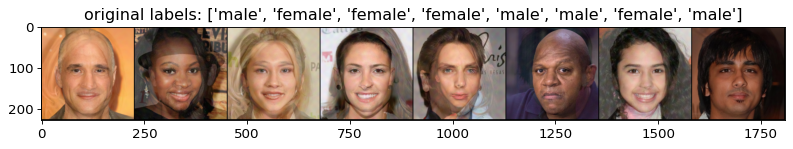

Iteration 201:  MSE = 0.020955 (reduced by 0.1502%), L2 norm = 51.7068 Feature distance = 33.7428 (reduced by 0.0506%)
Iteration 202:  MSE = 0.020886 (reduced by 0.3250%), L2 norm = 51.6281 Feature distance = 33.7035 (reduced by 0.1164%)
Iteration 203:  MSE = 0.020838 (reduced by 0.2334%), L2 norm = 51.5646 Feature distance = 33.6677 (reduced by 0.1063%)
Iteration 204:  MSE = 0.020768 (reduced by 0.3335%), L2 norm = 51.4862 Feature distance = 33.6395 (reduced by 0.0837%)
Iteration 205:  MSE = 0.020712 (reduced by 0.2706%), L2 norm = 51.4132 Feature distance = 33.6068 (reduced by 0.0974%)
Iteration 206:  MSE = 0.020652 (reduced by 0.2894%), L2 norm = 51.3408 Feature distance = 33.5682 (reduced by 0.1147%)
Iteration 207:  MSE = 0.020610 (reduced by 0.2027%), L2 norm = 51.2893 Feature distance = 33.5451 (reduced by 0.0690%)
Iteration 208:  MSE = 0.020551 (reduced by 0.2891%), L2 norm = 51.2143 Feature distance = 33.5085 (reduced by 0.1090%)
Iteration 209:  MSE = 0.020480 (reduced by 0.344

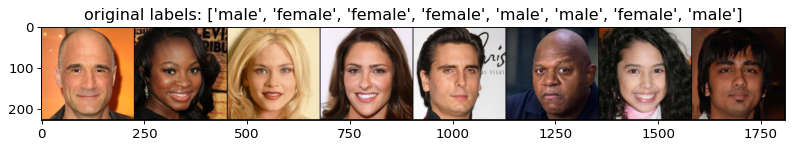

[Attack result examples]


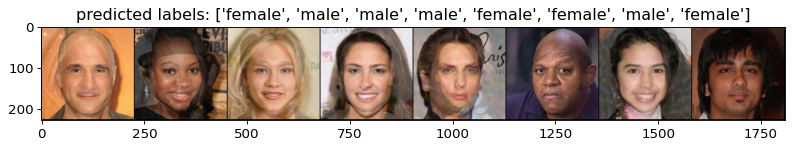

In [52]:
args = SimpleNamespace()
args.data_root = './celeba_hq_validation_100' # the root directory of a dataset
args.num_runs = 64 # number of repeated runs (number of images)
args.batch_size = 64 # batch size for parallel runs
args.num_steps = 300 # maximum number of iterations (number of queries)
args.perturb_mode = 'dct' # type of spherical perturbation sample (gaussian / dct)
args.spherical_step = 0.01 # spherical step size
args.source_step = 0.01 # source step size
args.dct_ratio = 0.125 # ratio of nonzero frequencies for dct

dct_mode = (args.perturb_mode == 'dct')

# load previously sampled set of images
testset = datasets.ImageFolder(args.data_root, transforms_val)
images = torch.zeros(args.num_runs, 3, 224, 224)
labels = torch.zeros(args.num_runs).long()
preds = labels + 1

# sample a new set of images that are correctly classified
while preds.ne(labels).sum() > 0:
    idx = torch.arange(0, images.size(0)).long()[preds.ne(labels)]
    for i in list(idx):
        images[i], labels[i] = testset[random.randint(0, len(testset) - 1)] # you can apply fixed seed
    preds[idx], _ = get_preds(model, images[idx], batch_size=args.batch_size)

# start attack
N = int(math.floor(float(args.num_runs) / float(args.batch_size)))
for i in range(N):
    print("==============================================================")
    print('[Attack start]')
    upper = min((i + 1) * args.batch_size, args.num_runs)
    images_batch = images[(i * args.batch_size):upper]
    labels_batch = labels[(i * args.batch_size):upper]
    perturbed = boundary_attack(
        model, images_batch, labels_batch, max_iters=args.num_steps,
        spherical_step=args.spherical_step, source_step=args.source_step,
        dct_mode=dct_mode, dct_ratio=args.dct_ratio)

    print('[Original examples]')
    imshow(images_batch.cpu(), labels_batch, 'original labels')

    preds, _ = get_preds(model, perturbed, batch_size=8, return_cpu=False)
    print('[Attack result examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')